In [1]:
import os
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications import NASNetLarge
from keras.applications.resnet_v2 import ResNet152V2

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix

import pandas as pd
import numpy as np
from glob import glob

import warnings  
warnings.filterwarnings('ignore')

In [2]:
entrada = '../input/leishmaniose-lamina/'
out = "./"
batch_size = 8
base_entrada = glob(entrada)[0] # Pega a string do nome da pasta

In [3]:
models = [InceptionV3(weights='imagenet',include_top=True), 
          Xception(weights='imagenet',include_top=True), 
          InceptionResNetV2(weights='imagenet',include_top=True),
          NASNetLarge(weights='imagenet',include_top=True), 
          ResNet152V2(weights='imagenet',include_top=True)]

242753536/242745792 [==============================] - 2s 0us/step


In [4]:
data = ImageDataGenerator(rescale = 1./255) # reescala dos dados
# , rotation_range = 7, horizontal_flip = True, shear_range = 0.2, height_shift_range = 0.07, zoom_range = 0.2
for model in models:
    data_gen = data.flow_from_directory(base_entrada, target_size=(model.input.shape[1], model.input.shape[2]), batch_size=batch_size)

    print('Executando model {}'.format(model.name))
    model.layers.pop()
    name_model = model.name # nome do modelo
    model = Model(inputs=model.input,outputs=model.layers[-1].output)
    features = model.predict(data_gen)

    save = np.concatenate([features, np.reshape(data_gen.labels,(-1,1))], axis=1)
    np.savetxt('leishmaniose_{}.csv'.format(name_model), save, delimiter=',')

print(data_gen.class_indices)

Found 151 images belonging to 2 classes.
Executando model inception_v3
Found 151 images belonging to 2 classes.
Executando model xception
Found 151 images belonging to 2 classes.
Executando model inception_resnet_v2
Found 151 images belonging to 2 classes.
Executando model NASNet
Found 151 images belonging to 2 classes.
Executando model resnet152v2
{'Negativo': 0, 'Positivo': 1}


In [5]:
base_saida = glob(os.path.join(out, "*.csv"))

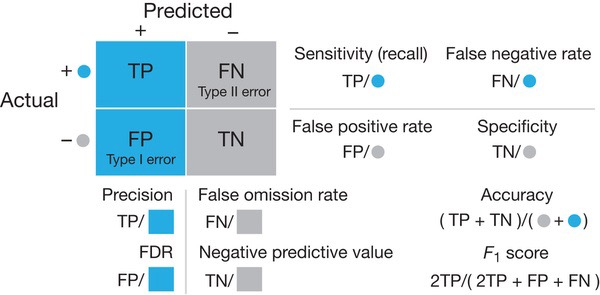

In [6]:
from IPython.display import Image
Image('../input/confusao/ConfusionMatrix.jpg')

In [7]:
# Calculo de métricas
def calculo_metricas(y_true, y_pred):    
    
    # tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # print(confusion_matrix(y_true, y_pred))
    acuracia = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1score = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    
    metricas = list(np.round([acuracia, precision, recall, f1score, kappa], 4))
    
    return metricas

In [8]:
# Balanceamento X_treino e Y_treino
def balanceamento_treino(X_treino, Y_treino):
    
    # Join
    dataset_treino = X_treino.join(Y_treino)

    # Classe 0 e 1
    classe0 = dataset_treino[dataset_treino.iloc[:,-1] == 0].count()[0]
    classe1 = dataset_treino[dataset_treino.iloc[:,-1] == 1].count()[0]

    # Valores0
    valores0 = dataset_treino[dataset_treino.iloc[:,-1] == 0].head(classe1 - classe0)

    # Dataset replicado
    dataset_treino_replicado = dataset_treino.append(valores0, ignore_index=True)

    # Definindo X_treino e X_teste
    X_treino = dataset_treino_replicado.iloc[:,0:-1]
    Y_treino = dataset_treino_replicado.iloc[:,-1]
    
    return X_treino, Y_treino

In [9]:
# Treinando com o Classificador Random Forest
def classificador_randomForest(X_treino, Y_treino, X_teste, Y_teste):
    
    print("--------------- Random Forest ----------------")
    classificador_v1 = RandomForestClassifier(random_state = 1, n_jobs = -1, n_estimators = 1000)
    classificador_v1.fit(X_treino, Y_treino)
    
#     # Verificando os dados de treino
#     predict_treino_v1 = classificador_v1.predict(X_treino)
#     print("Treino: ", calculo_metricas(Y_treino, predict_treino_v1))
    
    # Verificando nos dados de teste
    predict_teste_v1 = classificador_v1.predict(X_teste)
    print("Teste: ", calculo_metricas(Y_teste, predict_teste_v1))
    
    # Cross-Validation
    cross_validation = cross_val_score(classificador_v1, X, Y, scoring='accuracy', cv=10, n_jobs = -1)
    print("Cross-validation: ", list(np.round(cross_validation, 4)))
    print("Média CV: {0:.4f}".format(cross_validation.mean()))
    print("STD CV: {0:.4f}".format(cross_validation.std()))

In [10]:
# Treinando com o SVM
def classificador_svm(X_treino, Y_treino, X_teste, Y_teste):
    
    print("\n------------------ SVM ---------------------")
    # Treinando com o Classificador SVM
    classificador_v2 = svm.SVC(random_state = 1)
    classificador_v2.fit(X_treino, Y_treino)
    
    # Verificando os dados de treino
#     predict_treino_v2 = classificador_v2.predict(X_treino)
#     print("Treino: ", calculo_metricas(Y_treino, predict_treino_v2))
    
    # Verificando nos dados de teste
    predict_teste_v2 = classificador_v2.predict(X_teste)
    print("Teste: ", calculo_metricas(Y_teste, predict_teste_v2))
    
    # Cross-Validation
    cross_validation = cross_val_score(classificador_v2, X, Y, scoring='accuracy', cv=10, n_jobs = -1)
    print("Cross-validation: ", list(np.round(cross_validation, 4)))
    print("Média CV: {0:.4f}".format(cross_validation.mean()))
    print("STD CV: {0:.4f}".format(cross_validation.std()))

In [11]:
# Treinando com o XGBooster
def classificador_xgbooster(X_treino, Y_treino, X_teste, Y_teste):
    
    print("\n--------------- XGBooster ------------------")
    # Treinando com o Classificador XGBClassifier
    classificador_v3 = XGBClassifier(random_state = 1, n_jobs = -1, n_estimators = 1000, eval_metric='mlogloss')
    classificador_v3.fit(X_treino, Y_treino) 
    
    # Verificando os dados de treino
#     predict_treino_v3 = classificador_v3.predict(X_treino)
#     print("Treino: ", calculo_metricas(Y_treino, predict_treino_v3))
    
    # Verificando nos dados de teste
    predict_teste_v3 = classificador_v3.predict(X_teste)
    print("Teste: ", calculo_metricas(Y_teste, predict_teste_v3))
    
    # Cross-Validation
    cross_validation = cross_val_score(classificador_v3, X, Y, scoring='accuracy', cv=10, n_jobs = -1)
    print("Cross-validation: ", list(np.round(cross_validation, 4)))
    print("Média CV: {0:.4f}".format(cross_validation.mean()))
    print("STD CV: {0:.4f}".format(cross_validation.std()))

In [12]:
# Classificação Random Forest
print("Métricas Y_teste: [Acurácia, Precision, Recall, F1-score, Kappa]\n\n")

for base in base_saida:
    print("Base: ", base)
    
    # Leitura da base
    dataset = pd.read_csv(base, header=None)
    
    # Divisão entre treino e teste
    X = dataset.iloc[:, 0:-1]
    Y = dataset.iloc[:,-1]
    X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify=Y)
    
    # Balancemanento das classes no treinamento (replicar os dados da classe minoritária no treinamento)
    # X_treino, Y_treino = balanceamento_treino(X_treino, Y_treino)
    
    # Random Forest
    classificador_randomForest(X_treino, Y_treino, X_teste, Y_teste)
    
    # SVM
    classificador_svm(X_treino, Y_treino, X_teste, Y_teste)
    
    # XGBooster
    classificador_xgbooster(X_treino, Y_treino, X_teste, Y_teste)
    
    print("\n\n")

Métricas Y_teste: [Acurácia, Precision, Recall, F1-score, Kappa]


Base:  ./leishmaniose_xception.csv
--------------- Random Forest ----------------
Teste:  [0.5161, 0.5294, 0.5625, 0.5455, 0.0292]
Cross-validation:  [0.4375, 0.4, 0.4, 0.5333, 0.4667, 0.4667, 0.5333, 0.5333, 0.5333, 0.4667]
Média CV: 0.4771
STD CV: 0.0514

------------------ SVM ---------------------
Teste:  [0.4194, 0.4615, 0.75, 0.5714, -0.1872]
Cross-validation:  [0.4375, 0.4667, 0.4, 0.6, 0.6, 0.5333, 0.6, 0.4, 0.4, 0.4667]
Média CV: 0.4904
STD CV: 0.0814

--------------- XGBooster ------------------
Teste:  [0.5161, 0.5294, 0.5625, 0.5455, 0.0292]
Cross-validation:  [0.3125, 0.2667, 0.4667, 0.6, 0.4, 0.4667, 0.6667, 0.5333, 0.4, 0.2667]
Média CV: 0.4379
STD CV: 0.1291



Base:  ./leishmaniose_inception_resnet_v2.csv
--------------- Random Forest ----------------
Teste:  [0.5806, 0.6154, 0.5, 0.5517, 0.1656]
Cross-validation:  [0.4375, 0.6, 0.4, 0.4, 0.5333, 0.3333, 0.4667, 0.3333, 0.6667, 0.4667]
Média CV: 0.4637


In [13]:
Y_treino.value_counts()

1.0    63
0.0    57
Name: 1000, dtype: int64

In [14]:
Y_teste.value_counts()

1.0    16
0.0    15
Name: 1000, dtype: int64